# Wrapper Methods

1. Forward Feature Selection
2. Backward Feature Selection
3. Exhaustive Search

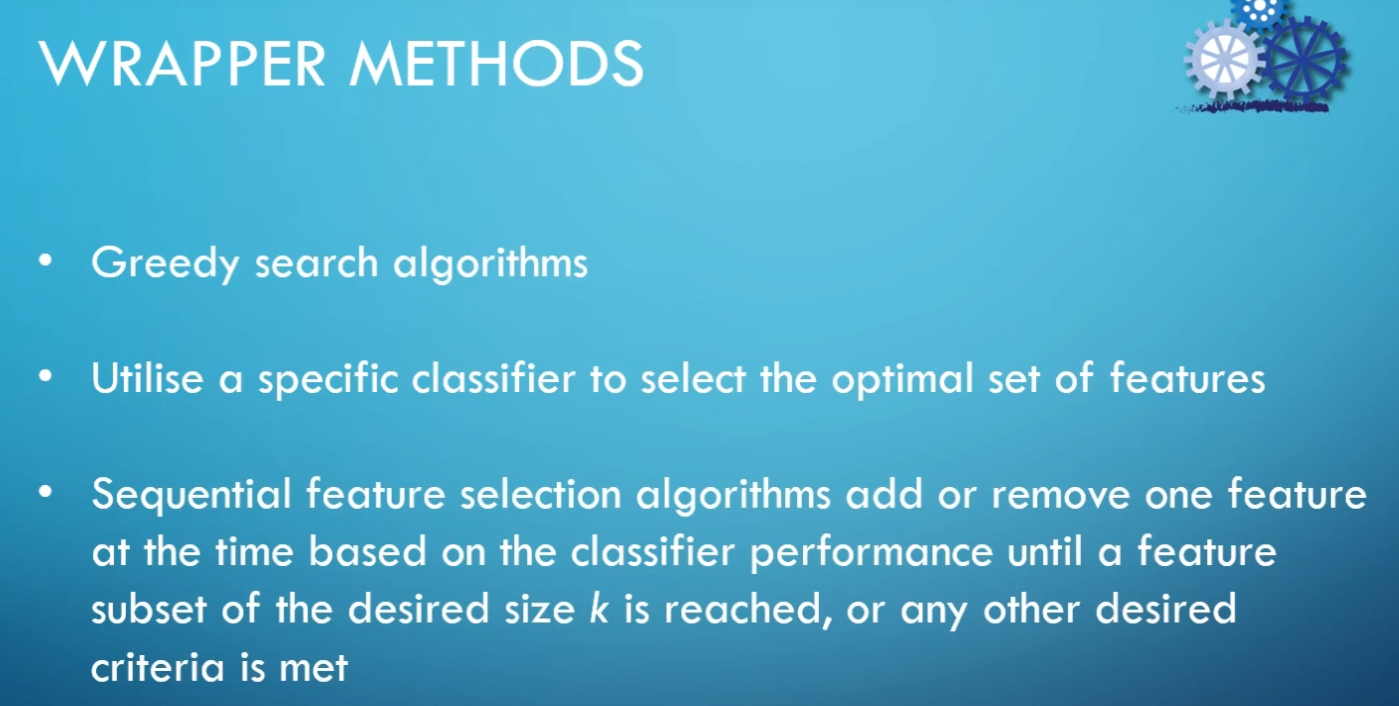

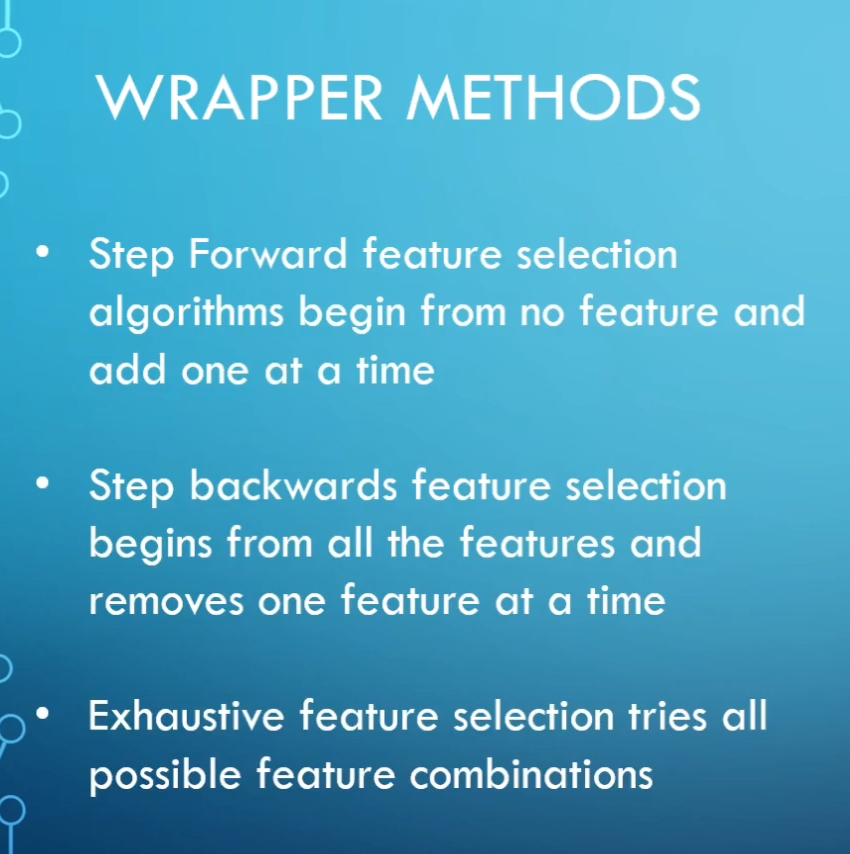

# FORWARD FEATURE SELECTION

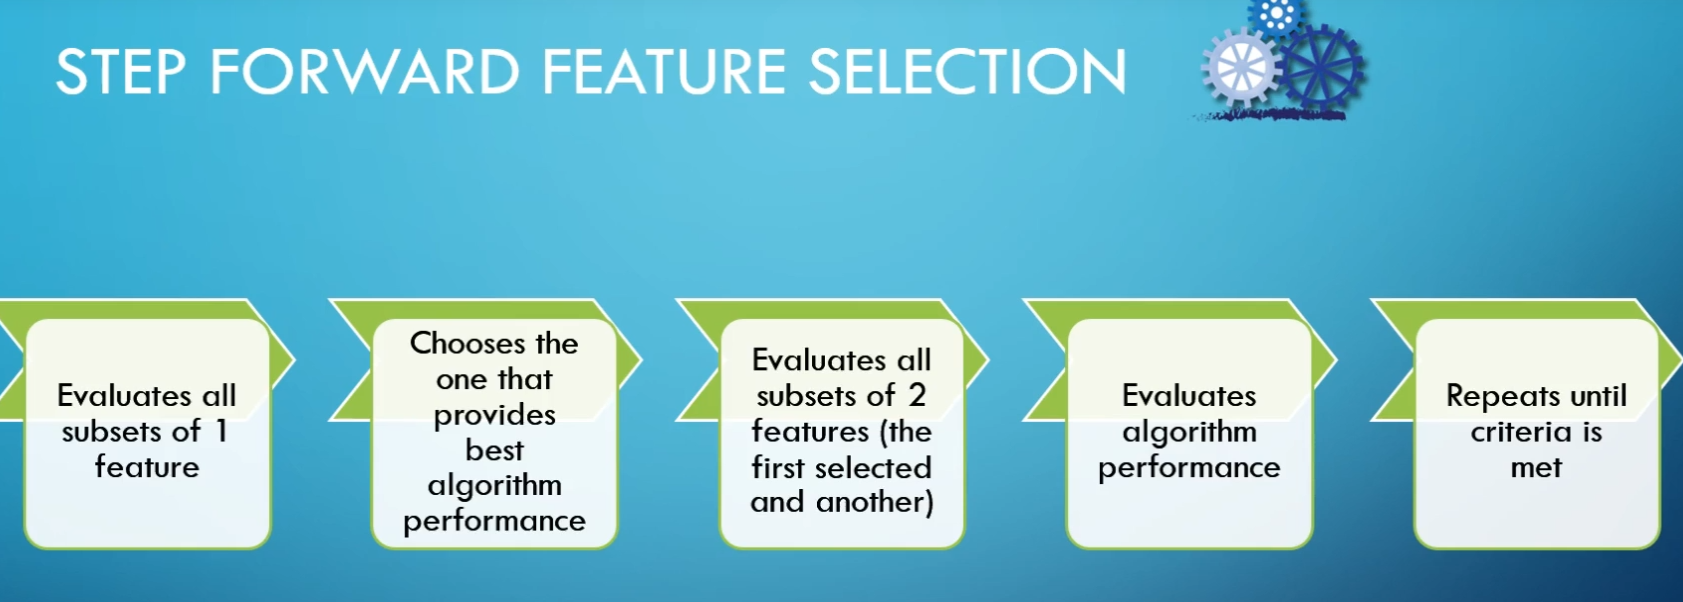

In [2]:
import mlxtend 

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [5]:
data= pd.read_csv(r'C:\Users\VigneshSS\Desktop\Feature Selection for Machine Learning\precleaned-datasets\dataset_2.csv')
data.head()

var_1      var_2      var_3     var_4     var_5     var_6     var_7  \
0  4.532710   3.280834  17.982476  4.404259  2.349910  0.603264  2.784655   
1  5.821374  12.098722  13.309151  4.125599  1.045386  1.832035  1.833494   
2  1.938776   7.952752   0.972671  3.459267  1.935782  0.621463  2.338139   
3  6.020690   9.900544  17.869637  4.366715  1.973693  2.026012  2.853025   
4  3.909506  10.576516   0.934191  3.419572  1.871438  3.340811  1.868282   

      var_8      var_9     var_10  ...   var_100   var_101   var_102  \
0  0.323146  12.009691   0.139346  ...  2.079066  6.748819  2.941445   
1  0.709090   8.652883   0.102757  ...  2.479789  7.795290  3.557890   
2  0.344948   9.937850  11.691283  ...  1.861487  6.130886  3.401064   
3  0.674847  11.816859   0.011151  ...  1.340944  7.240058  2.417235   
4  0.439865  13.585620   1.153366  ...  2.738095  6.565509  4.341414   

     var_103    var_104   var_105   var_106   var_107   var_108   var_109  
0  18.360496  17.726613  7.774031  1.473441  1.973832  0.976806  2.541417  
1  17.383378  15.193423  8.263673  1.878108  0.567939  1.018818  1.416433  
2  15.850471  14.620599  6.849776  1.098210  1.959183  1.575493  1.857893  
3  15.194609  13.553772  7.229971  0.835158  2.234482  0.946170  2.700606  
4  15.893832  11.929787  6.954033  1.853364  0.511027  2.599562  0.811364  

[5 rows x 109 columns]

In [6]:
data.shape

(50000, 109)

In [7]:
# separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

In [8]:
# within the SFS we indicate:

# 1) the algorithm we want to create, in this case RandomForests
# (note that I use few trees to speed things up)

# 2) the stopping criteria: want to select 10 features 

# 3) wheter to perform step forward or step backward

# 4) the evaluation metric: in this case the roc_auc
# 5) the cross-validation

# this is going to take a while, do not despair

sfs = SFS(RandomForestClassifier(n_estimators=10, n_jobs=4, random_state=0), 
           k_features=10, # the more features we want, the longer it will take to run
           forward=True, 
           floating=False, # see the docs for more details in this parameter
           verbose=2, # this indicates how much to print out intermediate steps
           scoring='roc_auc',
           cv=2)

sfs = sfs.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.1min finished

[2020-12-16 14:49:58] Features: 1/10 -- score: 0.5801166149124996[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:  1.7min finished

[2020-12-16 14:51:38] Features: 2/10 -- score: 0.6134428807979182[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:  1.6min finished

[2020-12-16 14:53:13] Features: 3/10 -- score: 0.6453233778190219[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [9]:
selected_feat = X_train.columns[list(sfs.k_feature_idx_)]
selected_feat

Index(['var_14', 'var_16', 'var_19', 'var_38', 'var_45', 'var_55', 'var_57',
       'var_70', 'var_91', 'var_108'],
      dtype='object')

### Compare performance of feature subsets

In [10]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [11]:
# evaluate performance of algorithm built
# using selected features

run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.7134269424069968
Test set
Random Forests roc-auc: 0.7021947404909273


In [12]:
# and for comparison, we train random forests using
# all features (except the correlated ones, which we removed already)

run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.7112958732101679
Test set
Random Forests roc-auc: 0.6955240210751086


# Regression

# BACKWARD FEATURE SELECTION

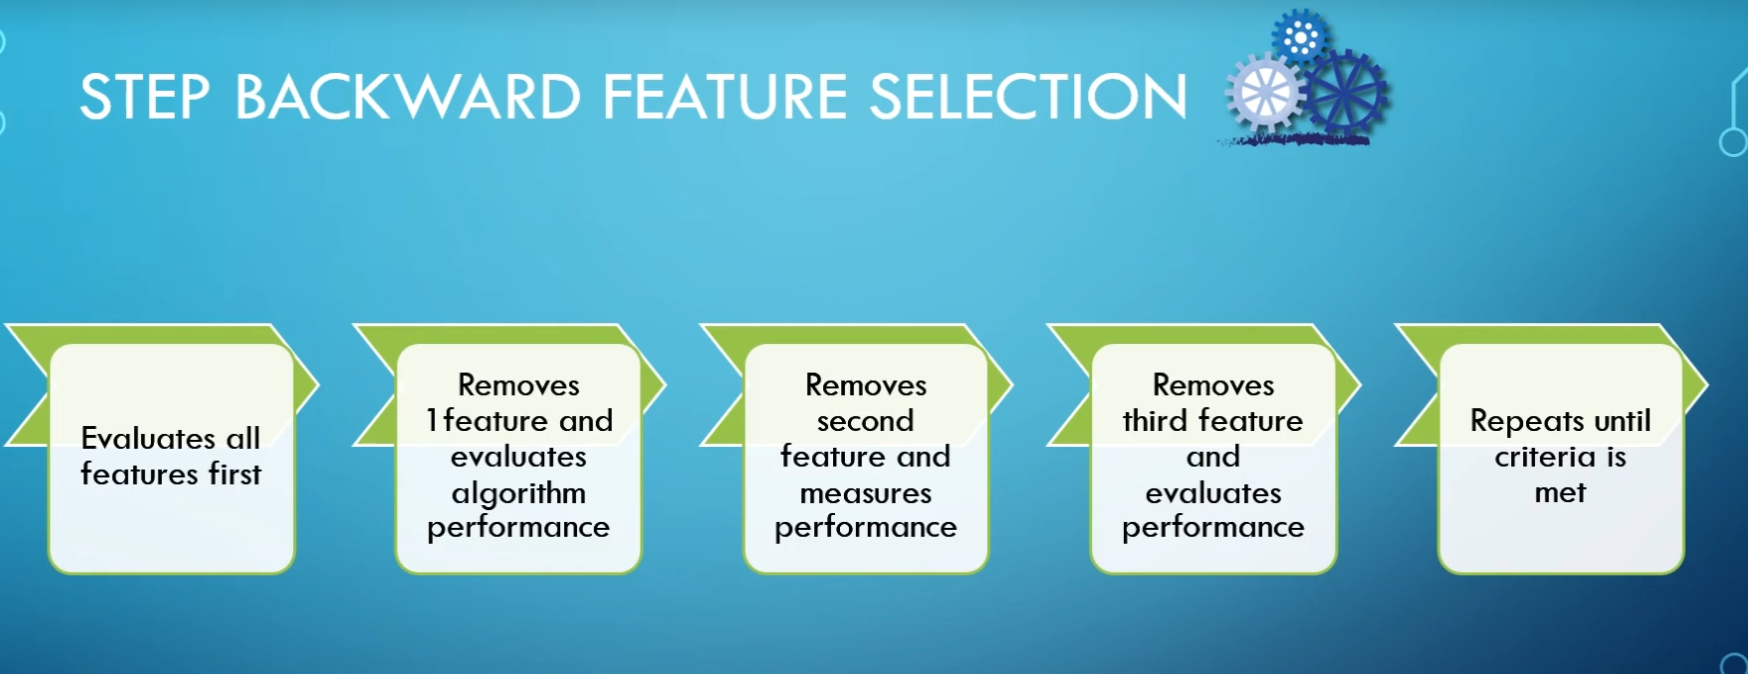

# EXHAUSTIVE FEATURE SELECTION

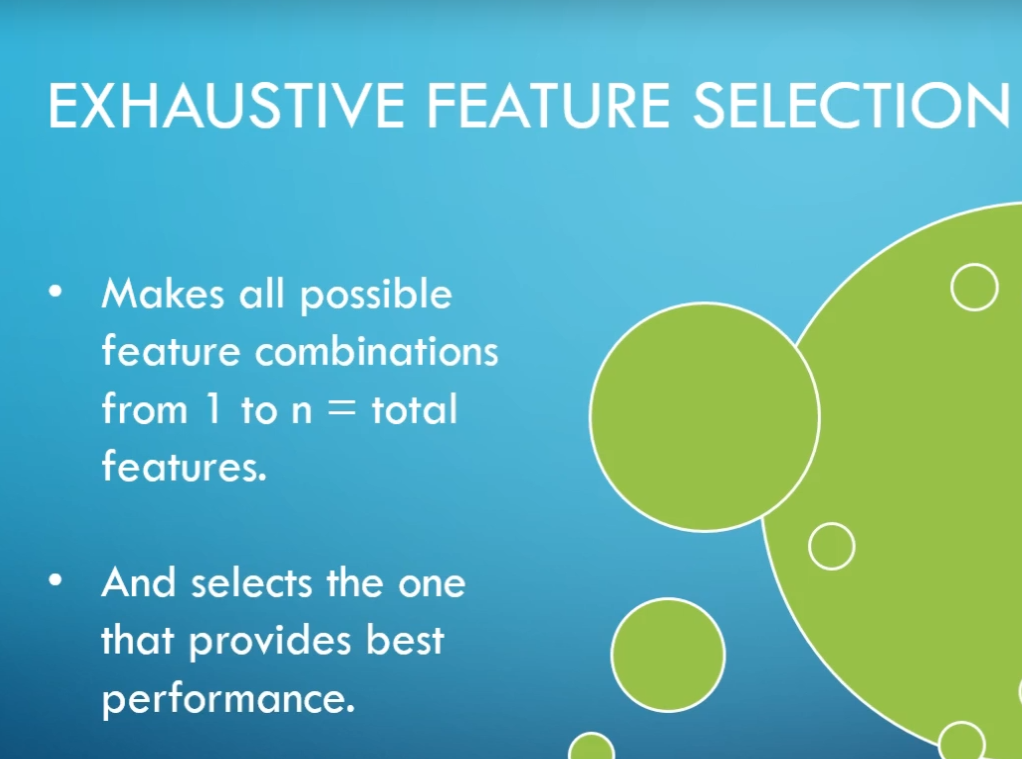

In [13]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [14]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

In [15]:
##################################

# in order to shorter search time for the demonstration
# i will ask the algorithm to try all possible 1 and 2
# feature combinations

# if you have access to a multicore or distributed computer
# system you can try more greedy searches

###################################

# within the EFS we indicate:

# 1) the algorithm we want to create, in this case RandomForests
# (note that I use few trees to speed things up)

# 2) the number of minimum features we want our model to have

# 3) the number of maximum features we want our model to have

# with 2 and 3 we regulate the number of possible feature combinations to
# be evaluated by the model.

# 4) the evaluation metric: in this case the roc_auc
# 5) the cross-validation

# this is going to take a while, do not despair

efs = EFS(RandomForestClassifier(n_estimators=5,
                                 n_jobs=4,
                                 random_state=0,
                                 max_depth=2),
          min_features=1,
          max_features=2,
          scoring='roc_auc',
          print_progress=True,
          cv=2)

# search features
efs = efs.fit(np.array(X_train), y_train)

Features: 5886/5886

In [16]:
efs.best_idx_

(15, 54)

In [17]:
selected_feat = X_train.columns[list(efs.best_idx_)]
selected_feat

Index(['var_16', 'var_55'], dtype='object')

In [18]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [19]:
# evaluate performance of classifier using selected features

run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.7035772664841601
Test set
Random Forests roc-auc: 0.6965072903754118


In [20]:
# and for comparison, we train random forests using
# all features (except the correlated ones, which we removed already)

run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.7112958732101679
Test set
Random Forests roc-auc: 0.6955240210751086


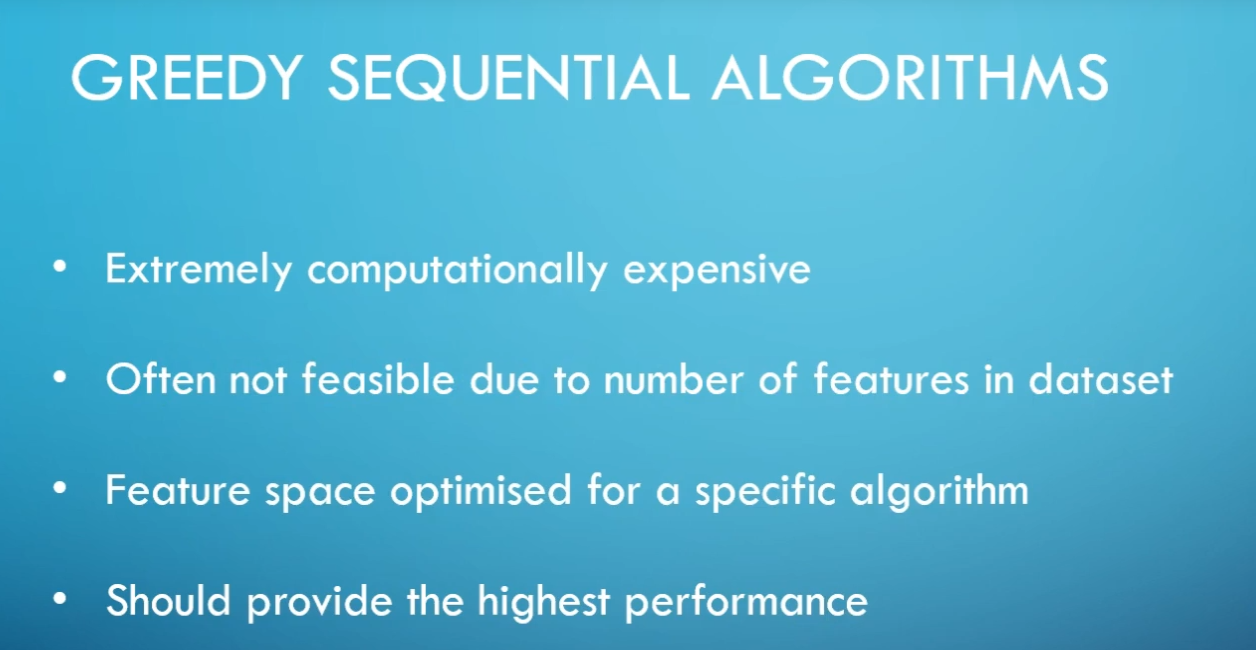